# Matteo_Challenge1: Hand-Crafted Solution

## Import libraries

In [1]:
import os
import random
from datetime import datetime

import splitfolders

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Checking tensorflow version
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [3]:
# Setting seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Model Parameters and Classes Weights

In [4]:
labels = ['Species1',      # 0
          'Species2',      # 1
          'Species3',      # 2
          'Species4',      # 3
          'Species5',      # 4
          'Species6',      # 5
          'Species7',      # 6
          'Species8']      # 7

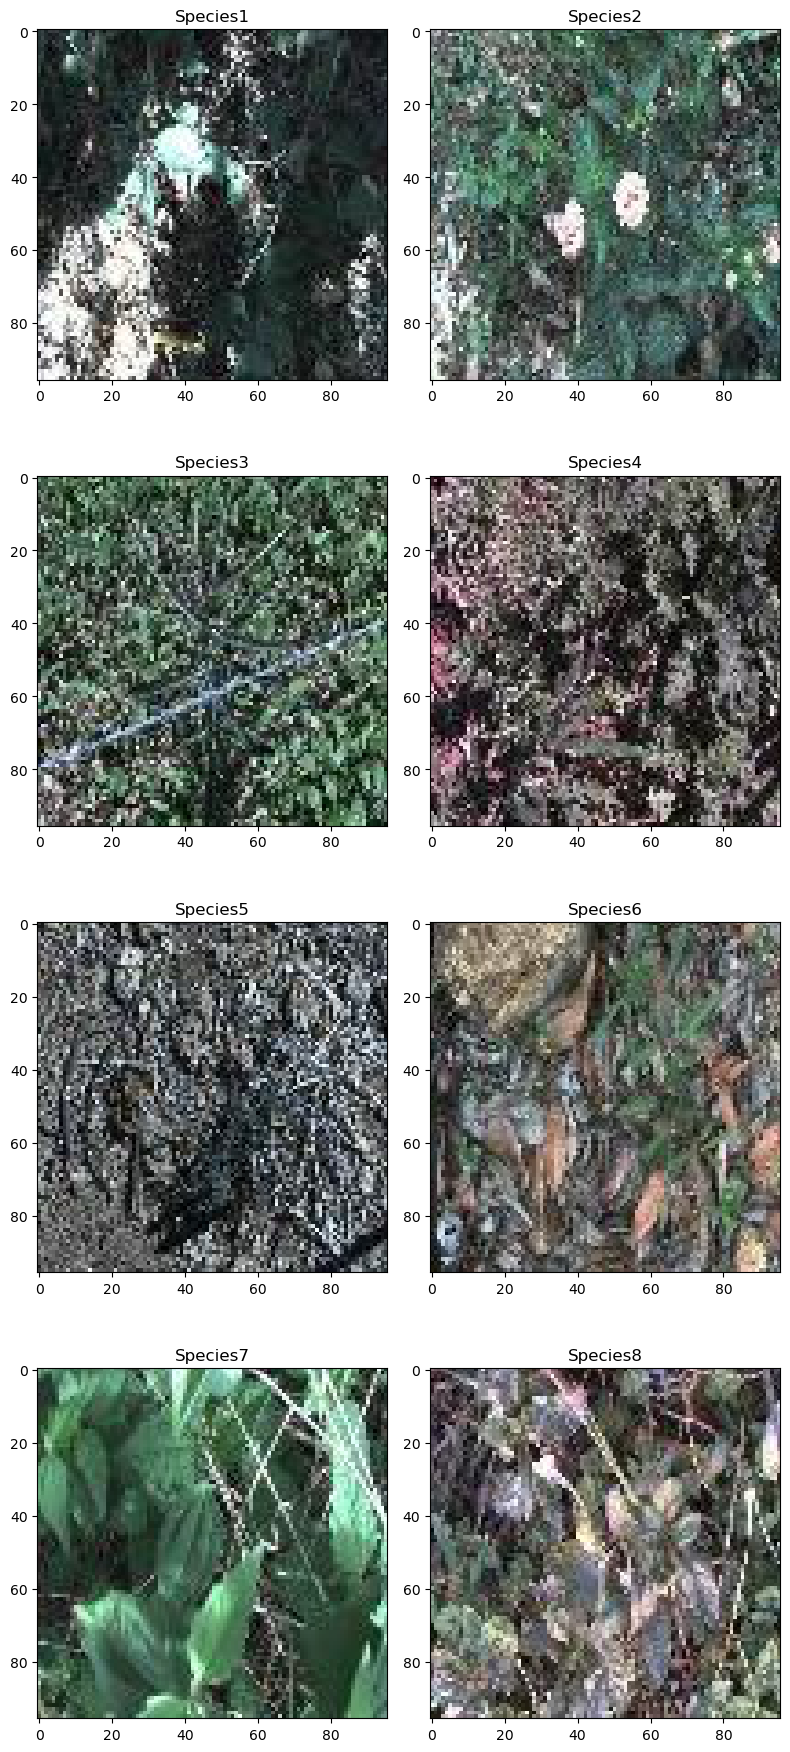

In [5]:
dataset_dir = 'Dataset'

num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
    if i < 8:
        class_imgs = next(os.walk('{}/{}'.format(dataset_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Model Parameters and Metadata

In [6]:
# Input Parameters
img_w = 96
img_h = 96
input_shape = (96, 96, 3)
classes = 8

# Training Parameters
epochs = 90
batch_size = 64
reg_rate = 0.001

# Earlystopping Parameters
early_stopping = False
patience_epochs = 9

# Training and Validation Folders
training_dir = os.path.join(dataset_dir, '../datasetWithoutTest/train')
validation_dir = os.path.join(dataset_dir, '../datasetWithoutTest/val')

## Data Augmentation

In [7]:
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

In [8]:
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=labels,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=labels,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


In [9]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [10]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))

    return batch

(Input) image shape: (64, 96, 96, 3)
Target shape: (64, 8)

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
Label: 3
Class name: Species4


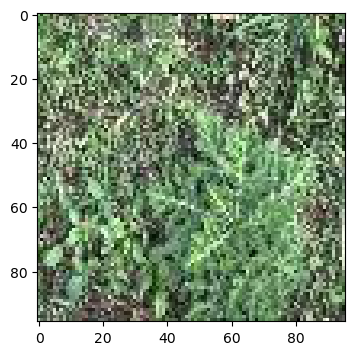

In [11]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

## Data Augmentation


Rotation: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': 38, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.9247240713084175, 'zy': 1.2704285838459497, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Rescaled')

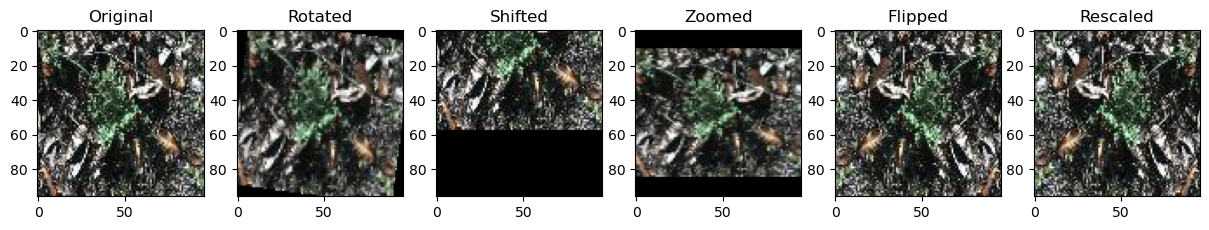

In [12]:
# Create some augmentation examples
# Get sample image
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True)
rescale_gen = ImageDataGenerator(rescale=1/255.)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Flip:', flip_t, '\n')
rescale_t = rescale_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Flip:', rescale_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t)
zoomed = gen.apply_transform(image, zoom_t)
flipped = gen.apply_transform(image, flip_t)
rescaled = gen.apply_transform(image, rescale_t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 6, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')
ax[5].imshow(np.uint8(flipped))
ax[5].set_title('Rescaled')

In [13]:
aug_train_data_gen =  ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         brightness_range=[0.2,1.2],
                                         fill_mode='nearest',
                                         rescale=1/255.)

In [14]:
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=labels,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

Found 2829 images belonging to 8 classes.


Transform: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}


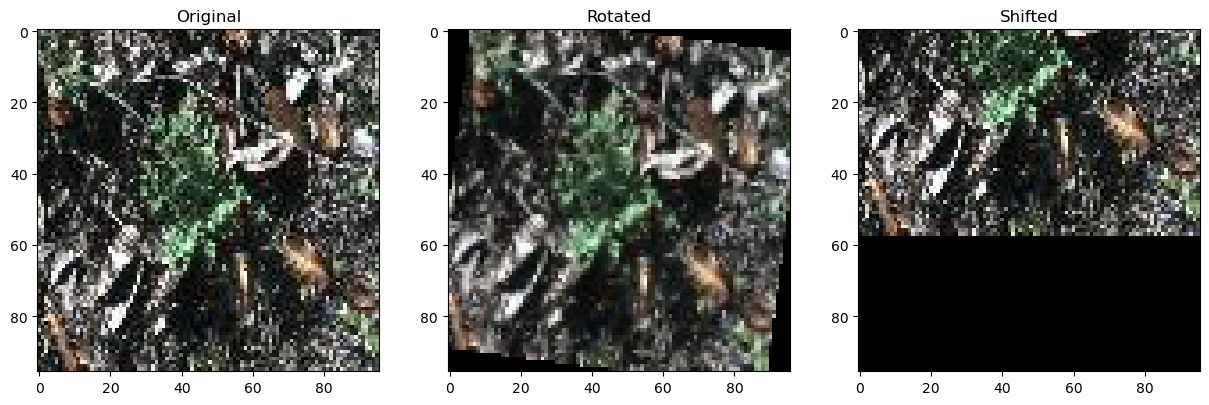

In [15]:
# Get random transformation
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print("Transform:", rot_t)

# Apply the transformation
augmented = gen.apply_transform(image, rot_t)
augmented2 = gen.apply_transform(image, shift_t)


# Plot original and augmented images
fig, ax = plt.subplots(1, 3, figsize=(15,30))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Rotated")
ax[2].imshow(np.uint8(augmented2))
ax[2].set_title("Shifted")
plt.show()

## CNN Model

In [16]:
def build_model(input_shape):

    # Layer Input -------------------------------------------------------
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Layer 1 -----------------------------------------------------------
    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        #activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    leaky_relu_layer1 = tfkl.LeakyReLU()(conv1)
    pool1 = tfkl.MaxPooling2D()(leaky_relu_layer1)

    # Layer 2 -----------------------------------------------------------
    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        #activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    leaky_relu_layer2 = tfkl.LeakyReLU()(conv2)

    pool2 = tfkl.MaxPooling2D()(leaky_relu_layer2)

    # Layer 3 -----------------------------------------------------------
    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        #activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    leaky_relu_layer3 = tfkl.LeakyReLU()(conv3)
    pool3 = tfkl.MaxPooling2D()(leaky_relu_layer3)

    # Layer 4 -----------------------------------------------------------
    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        #activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    leaky_relu_layer4 = tfkl.LeakyReLU()(conv4)

    pool4 = tfkl.MaxPooling2D()(leaky_relu_layer4)

    # Layer 5 -----------------------------------------------------------
    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        #activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    leaky_relu_layer5 = tfkl.LeakyReLU()(conv5)
    pool5 = tfkl.MaxPooling2D()(leaky_relu_layer5)

    # Flattening -----------------------------------------------------------
    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)

    # Dense Layer -----------------------------------------------------------
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)

    # Output Layer -----------------------------------------------------------
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Model Creation -----------------------------------------------------------
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                  optimizer=tfk.optimizers.Adam(),
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [17]:
model = build_model(input_shape)
model.summary()

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 64)        0         
                           

2022-11-12 23:07:37.354478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-12 23:07:37.354602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 24, 24, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12, 12, 256)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)      

## Utility Callbacks

In [18]:
# Utility function to create folders and callbacks for training
def create_folders_and_callbacks(model_name) :
    exps_dir = os.path.join('data_augmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint ---------------------------------------------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'), # filepath is where I want to save the model
                                                     save_weights_only=False, # save only the weights ora all the model
                                                     save_best_only=True) # if True saves only the results of the best epoch

    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard ----------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs') # logs where we save the events, where the tensorboard will read the logs
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                              profile_batch=0,
                                              histogram_freq=1)
    callbacks.append(tb_callback)

    # Early Stopping -----------------------------------------------------
    if early_stopping:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_epochs, restore_best_weights=True)
        callbacks.append(es_callback)

    return callbacks

## Training

In [19]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='HandCrafted_CNN')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = 90,
    validation_data = valid_gen,
    callbacks = callbacks,
).history

Epoch 1/90


2022-11-12 23:07:37.716278: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-12 23:07:38.268057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - ETA: 0s - loss: 2.5658 - accuracy: 0.1831 - precision: 0.1600 - recall: 0.0184

2022-11-12 23:07:43.811324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


45/45 [==============================] - 9s 174ms/step - loss: 2.5658 - accuracy: 0.1831 - precision: 0.1600 - recall: 0.0184 - val_loss: 307.4800 - val_accuracy: 0.2216 - val_precision: 0.2216 - val_recall: 0.2216
Epoch 2/90
45/45 [==============================] - 5s 115ms/step - loss: 1.8168 - accuracy: 0.3153 - precision: 0.4011 - recall: 0.0495 - val_loss: 472.7941 - val_accuracy: 0.2258 - val_precision: 0.2258 - val_recall: 0.2258
Epoch 3/90
45/45 [==============================] - 5s 106ms/step - loss: 1.6561 - accuracy: 0.3839 - precision: 0.5585 - recall: 0.0979 - val_loss: 554.8075 - val_accuracy: 0.2721 - val_precision: 0.2721 - val_recall: 0.2721
Epoch 4/90
45/45 [==============================] - 5s 108ms/step - loss: 1.5897 - accuracy: 0.4100 - precision: 0.5828 - recall: 0.1368 - val_loss: 620.7148 - val_accuracy: 0.3086 - val_precision: 0.3086 - val_recall: 0.3086
Epoch 5/90
45/45 [==============================] - 5s 110ms/step - loss: 1.4741 - accuracy: 0.4493 - preci

INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


45/45 [==============================] - 6s 142ms/step - loss: 1.1293 - accuracy: 0.5903 - precision: 0.7063 - recall: 0.4182 - val_loss: 250.3062 - val_accuracy: 0.4306 - val_precision: 0.4306 - val_recall: 0.4306
Epoch 16/90
45/45 [==============================] - 5s 108ms/step - loss: 1.2912 - accuracy: 0.5440 - precision: 0.6874 - recall: 0.3482 - val_loss: 474.6018 - val_accuracy: 0.3717 - val_precision: 0.3717 - val_recall: 0.3717
Epoch 17/90
45/45 [==============================] - 5s 108ms/step - loss: 1.1184 - accuracy: 0.5914 - precision: 0.7032 - recall: 0.4355 - val_loss: 461.1947 - val_accuracy: 0.2819 - val_precision: 0.2819 - val_recall: 0.2819
Epoch 18/90
45/45 [==============================] - 5s 105ms/step - loss: 1.1168 - accuracy: 0.5875 - precision: 0.7135 - recall: 0.4383 - val_loss: 282.6349 - val_accuracy: 0.4432 - val_precision: 0.4432 - val_recall: 0.4432
Epoch 19/90
45/45 [==============================] - 5s 107ms/step - loss: 1.0444 - accuracy: 0.6197 - p

INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


45/45 [==============================] - 6s 142ms/step - loss: 1.0305 - accuracy: 0.6214 - precision: 0.7344 - recall: 0.4857 - val_loss: 234.2539 - val_accuracy: 0.4516 - val_precision: 0.4516 - val_recall: 0.4516
Epoch 21/90
45/45 [==============================] - 5s 106ms/step - loss: 1.0135 - accuracy: 0.6331 - precision: 0.7355 - recall: 0.4935 - val_loss: 238.9989 - val_accuracy: 0.4698 - val_precision: 0.4698 - val_recall: 0.4698
Epoch 22/90
45/45 [==============================] - 5s 118ms/step - loss: 0.9939 - accuracy: 0.6363 - precision: 0.7345 - recall: 0.4998 - val_loss: 335.2191 - val_accuracy: 0.4376 - val_precision: 0.4376 - val_recall: 0.4376
Epoch 23/90
45/45 [==============================] - 5s 109ms/step - loss: 1.0185 - accuracy: 0.6214 - precision: 0.7441 - recall: 0.4935 - val_loss: 374.3511 - val_accuracy: 0.3745 - val_precision: 0.3745 - val_recall: 0.3745
Epoch 24/90
45/45 [==============================] - 5s 104ms/step - loss: 1.0056 - accuracy: 0.6296 - p

INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


45/45 [==============================] - 6s 140ms/step - loss: 0.9091 - accuracy: 0.6744 - precision: 0.7691 - recall: 0.5698 - val_loss: 139.1027 - val_accuracy: 0.5428 - val_precision: 0.5428 - val_recall: 0.5428
Epoch 31/90
45/45 [==============================] - 5s 103ms/step - loss: 0.8824 - accuracy: 0.6900 - precision: 0.7761 - recall: 0.5931 - val_loss: 214.4101 - val_accuracy: 0.5105 - val_precision: 0.5105 - val_recall: 0.5105
Epoch 32/90
45/45 [==============================] - 5s 109ms/step - loss: 0.8723 - accuracy: 0.6889 - precision: 0.7582 - recall: 0.5751 - val_loss: 209.4061 - val_accuracy: 0.4516 - val_precision: 0.4516 - val_recall: 0.4516
Epoch 33/90
45/45 [==============================] - 5s 117ms/step - loss: 0.8896 - accuracy: 0.6872 - precision: 0.7802 - recall: 0.5670 - val_loss: 323.1608 - val_accuracy: 0.4137 - val_precision: 0.4137 - val_recall: 0.4137
Epoch 34/90
45/45 [==============================] - 5s 108ms/step - loss: 0.8445 - accuracy: 0.6981 - p

INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


45/45 [==============================] - 6s 142ms/step - loss: 0.8356 - accuracy: 0.6971 - precision: 0.7769 - recall: 0.6105 - val_loss: 135.6197 - val_accuracy: 0.5764 - val_precision: 0.5764 - val_recall: 0.5764
Epoch 38/90
45/45 [==============================] - 5s 106ms/step - loss: 0.7920 - accuracy: 0.7250 - precision: 0.7956 - recall: 0.6426 - val_loss: 187.3218 - val_accuracy: 0.5288 - val_precision: 0.5288 - val_recall: 0.5288
Epoch 39/90
45/45 [==============================] - 5s 117ms/step - loss: 0.8059 - accuracy: 0.7112 - precision: 0.7918 - recall: 0.6250 - val_loss: 207.6321 - val_accuracy: 0.4993 - val_precision: 0.4993 - val_recall: 0.4993
Epoch 40/90
45/45 [==============================] - 5s 105ms/step - loss: 0.7666 - accuracy: 0.7257 - precision: 0.7973 - recall: 0.6423 - val_loss: 239.3919 - val_accuracy: 0.4446 - val_precision: 0.4446 - val_recall: 0.4446
Epoch 41/90
45/45 [==============================] - 5s 113ms/step - loss: 0.7543 - accuracy: 0.7292 - p

INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/HandCrafted_CNN_Nov12_23-07-37/ckpts/cp/assets


45/45 [==============================] - 6s 144ms/step - loss: 0.6834 - accuracy: 0.7632 - precision: 0.8150 - recall: 0.7038 - val_loss: 124.9320 - val_accuracy: 0.6592 - val_precision: 0.6592 - val_recall: 0.6592
Epoch 65/90
45/45 [==============================] - 5s 112ms/step - loss: 0.5729 - accuracy: 0.7936 - precision: 0.8430 - recall: 0.7458 - val_loss: 271.9205 - val_accuracy: 0.5442 - val_precision: 0.5442 - val_recall: 0.5442
Epoch 66/90
45/45 [==============================] - 5s 106ms/step - loss: 0.5690 - accuracy: 0.7996 - precision: 0.8421 - recall: 0.7522 - val_loss: 520.8171 - val_accuracy: 0.4236 - val_precision: 0.4236 - val_recall: 0.4236
Epoch 67/90
45/45 [==============================] - 5s 115ms/step - loss: 0.6121 - accuracy: 0.7893 - precision: 0.8430 - recall: 0.7367 - val_loss: 235.4738 - val_accuracy: 0.5288 - val_precision: 0.5288 - val_recall: 0.5288
Epoch 68/90
45/45 [==============================] - 5s 113ms/step - loss: 0.5865 - accuracy: 0.8042 - p

In [20]:
# Saving the last epoch of the train
save_dir = os.path.join('HandCrafted_CNN')
model.save(save_dir)

INFO:tensorflow:Assets written to: HandCrafted_CNN/assets


INFO:tensorflow:Assets written to: HandCrafted_CNN/assets


## Graphs Visualization

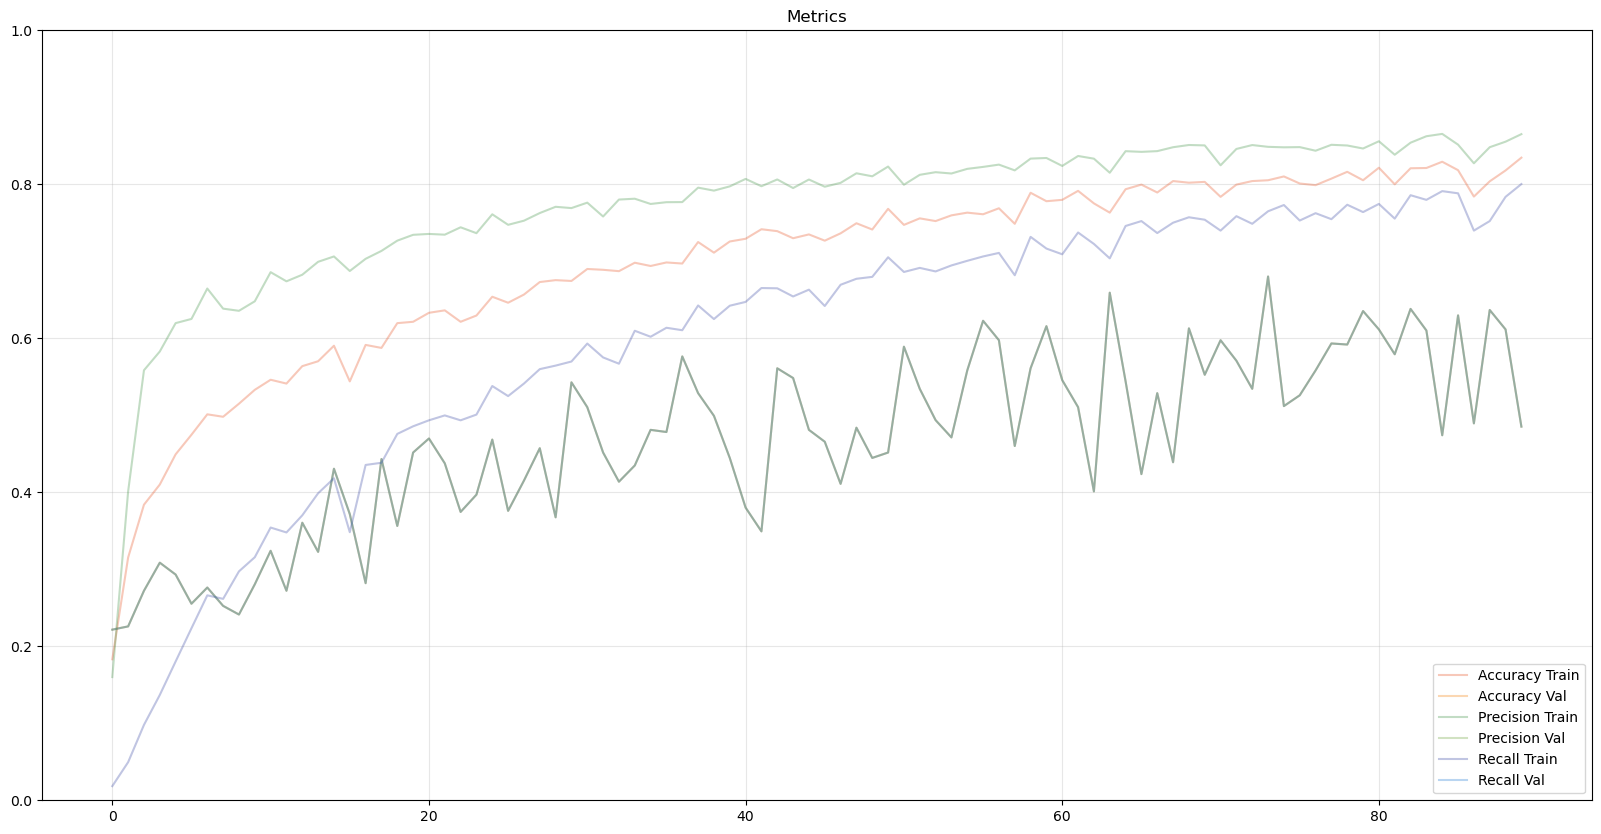

In [21]:
# All the metrics : Accuracy, Precision and Recall
ALPHA = 0.3

plt.figure(figsize=(20,10))

plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19')
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00')

plt.plot(history['precision'], label='Precision Train', alpha=ALPHA, color='#388E3C')
plt.plot(history['val_precision'], label='Precision Val', alpha=ALPHA, color='#689F38')

plt.plot(history['recall'], label='Recall Train', alpha=ALPHA, color='#303F9F')
plt.plot(history['val_recall'], label='Recall Val', alpha=ALPHA, color='#1976D2')

plt.ylim(0, 1)
plt.title('Metrics')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

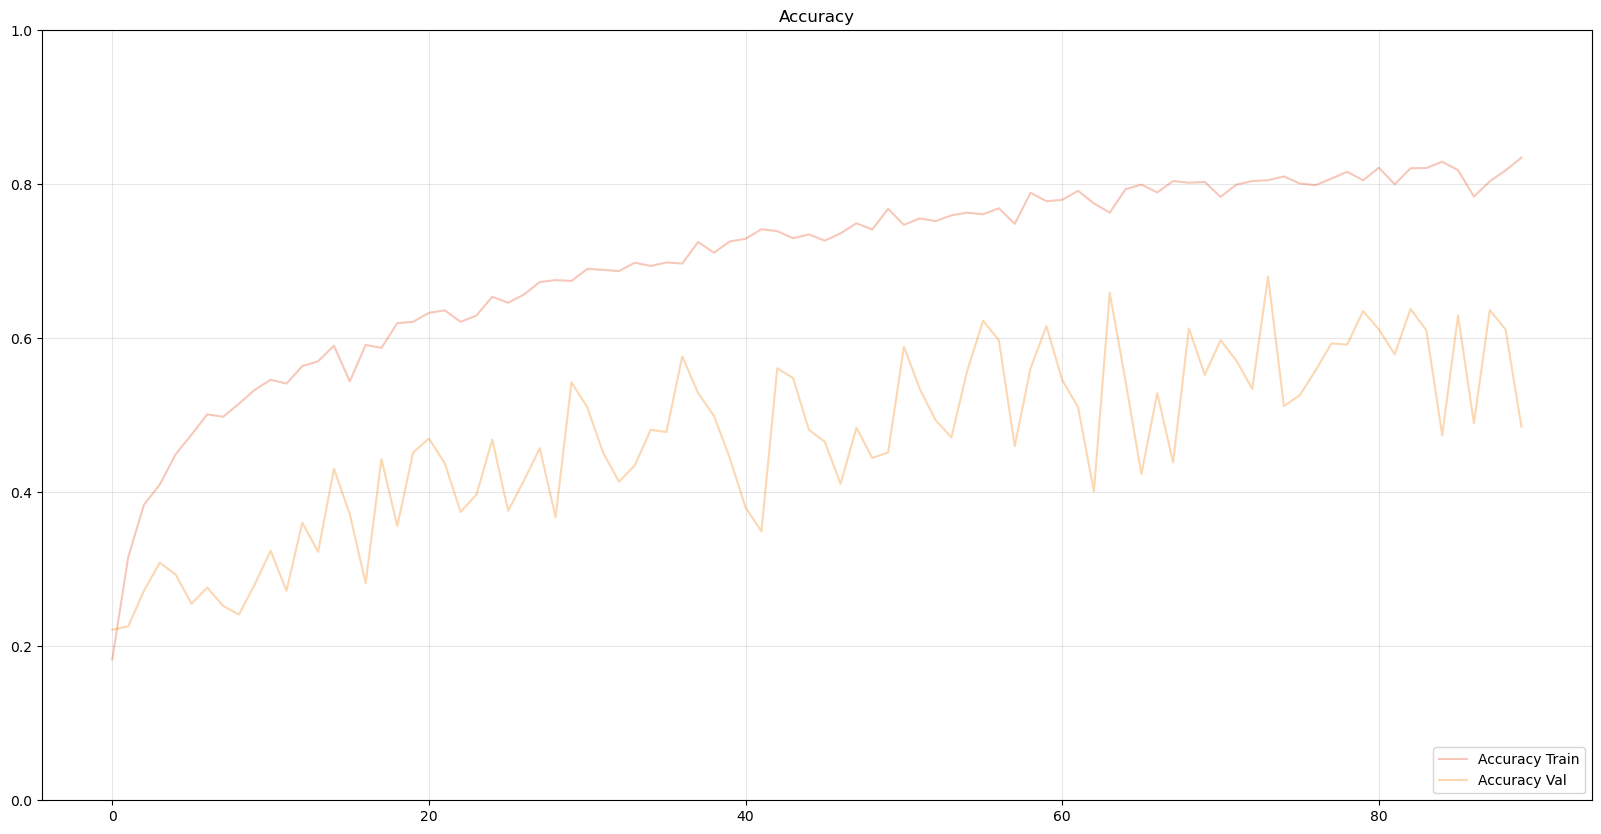

In [22]:
# Accuracy Graph
plt.figure(figsize=(20,10))

plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19')
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00')

plt.ylim(0, 1)
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

In [23]:
# Precision Graph
plt.figure(figsize=(20,10))

plt.plot(history['precision_1'], label='Precision Train', alpha=ALPHA, color='#388E3C')
plt.plot(history['val_precision_1'], label='Precision Val', alpha=ALPHA, color='#689F38')

plt.ylim(0, 1)
plt.title('Precision')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

KeyError: 'precision_1'

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Recall Graph
plt.figure(figsize=(20,10))

plt.plot(history['recall_1'], label='Recall Train', alpha=ALPHA, color='#303F9F')
plt.plot(history['val_recall_1'], label='Recall Val', alpha=ALPHA, color='#1976D2')

plt.ylim(0, 1)
plt.title('Recall')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Loss Graph
plt.figure(figsize=(15,10))

plt.plot(history['loss'], label='Loss Train', alpha=ALPHA, color='#ff7f0e')
plt.plot(history['val_loss'], label='Loss Val', alpha=ALPHA, color='#4D61E2')

plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()